First attempt at creating the replicants I imagined.
We will be using mesa, to simulate the agents interacting.
Later on we will use networkx, to greate interesting Graphs for them to live in.
But for now, all we want is a minimal working prototype.

The goal is to find the smalles common denominator of replicant systems.
Find the smallest, simplest ruleset that can emulate interesing/complex behaviour seen in genes as well as memes.

First, lets define the replicants themselves. They won't be the agents of the *simulation* even though they are the  "agents" in our *theoretical model*. This is because

1. We can derive the optimal (or a close approximation thereof) decisions of the replicants analytically.

2. The mesa framework appears to lend itsself better to regarding the vehicles which contain the replicants as agents.

In [1]:
    %matplotlib inline 
    #no idea what this does
    
    import matplotlib.pyplot as plt

In [2]:
import random
random.seed(1234)

from replicant import Replicant

The only thing that defines a Replicant is its single attribute, a value between -1 and 1.

Let us define the optimisation probelm that our Replicants must solve together. We choose the Knapsack problem because it is a difficult problem, highly nonliear in its inputs, and adds a minimal overhead of assumptions.

We are open to alternative suggestions.

In [3]:
import knapsack

Now, we can define our vehicles. (Which mesa calls agents)

In [4]:
from mesa import Agent

In [5]:
from vehicle import Vehicle
from replicant import Replicant

In [6]:
from mesa import Model
from mesa.time import StagedActivation
from mesa.space import SingleGrid

class RepModel(Model):
    """A model for Replicants."""
    def __init__(self):
        self.schedule = StagedActivation(self, ["mutate", "interact"], True, True)
        # Args:
        #    model: Model object associated with the schedule.
        #    stage_list: List of strings of names of stages to run, in the
         #                order to run them in.
          #  shuffle: If True, shuffle the order of agents each step.
           # shuffle_between_stages: If True, shuffle the agents after each
            #                        stage; otherwise, only shuffle at the start
             #                       of each step.
        
        self.grid = SingleGrid(10,10,True)
        
        #create initial agent(s).
        primordial_vehicle = Vehicle(1, self, [Replicant(), Replicant()])
        
        #place in schedule
        self.schedule.add(primordial_vehicle)
        
        #place in grid
        self.grid.place_agent(primordial_vehicle, (1,1))
        
        # create and place evil twin.
        replicant2 = Replicant()
        replicant3 = Replicant()
        vehicle2 = Vehicle(2, self, [replicant3,Replicant()])
        
        #place in schedule
        self.schedule.add(vehicle2)
        
        #place in grid
        self.grid.place_agent(vehicle2, (6,6))
        
    def step(self):
        """Advance model by one step."""
        self.schedule.step()

In [7]:
testmodel = RepModel()
testmodel.grid

768  has mutated to  330
751  has mutated to  92
993  has mutated to  734
870  has mutated to  730
557  has mutated to  435
469  died, due to deleting its last Replicant.
687  died, due to deleting its last Replicant.
262  died, due to deleting its last Replicant.
373  died, due to deleting its last Replicant.
169  died, due to deleting its last Replicant.
214  died, due to deleting its last Replicant.
462  died, due to deleting its last Replicant.


ValueError: empty range for randrange() (0, 0, 0)

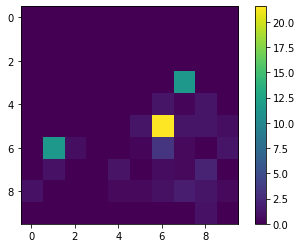

In [36]:
# VISUALISE; YEAH!

import numpy as np

cell_fitness = np.zeros((testmodel.grid.width, testmodel.grid.height))
for cell in testmodel.grid.coord_iter():
    cell_content, x, y = cell
    if not testmodel.grid.is_cell_empty((x,y)):
        cell_fitness[x][y] = cell_content.fitness

plt.imshow(cell_fitness)
plt.colorbar()

testmodel.step()
print([a.unique_id for a in testmodel.schedule.agents])

Houston, we have a problem.

We are using the "StagedActivation" mode to have two different stages. "mutate" in which the vehicles mutate, and "interact",
in which they interact.
The problem is: the schedule is apparently not updated between stages.
That means:
    1. We get key errors when agents are requested that were deleted in the last stage.
    2. We miss agents that were created in the last stage.

Options:
    1. Research StagedActivation for known fixes.
    2. Fix mutate() and interact() to play nice together.
        - Mark for deletion, but only delete in the last stage?
        - Seems like a fucky solution.
    3.Integrate both stages into one step() function.
        - Either deterministically: store a round variable that is either "mutate" or "interact"
        - or probabilistically: 0.5 chance to interact(). 0.5 chance to mutate(). (mutate() still rolls the dice if you actually mutate or not! 0.5 is only the chance to have a "mutate" round!)

Actually, the problem might run deeper :(

Question: Are dead agents, that were killed earlier in the round/step, by another agent whos turn was earlier that round/step,
really dead? Or are they called by the schedule? If that is the case, we can basically throw out this whole project
and go back to java... :(

That would mean that the activation order only matters to the grid, which is live, while the schedule is only updated at once per round.

